**CNN for the detection of COVID-19 in CT scans images**

The aim of the following project is to train a convolutional neural network to detect clinical signs of COVID-19 from chest CT scan images. CT and other chest imaging techniques have proven to be instrumental in helping practitioners to diagnose the disease during the outbreak of COVID-19.
The COVID-CT dataset used in this project was created by Zhao et al. (2020) and it is organized in two folders:


*   The CT_COVID folder contains 349 chest CT images depicting clinical findings of COVID-19 from 216 patients.
*   The CT_NonCOVID folder contains a set of 397 chest CT negative CT scans that are normal or contain other types of diseases. CT negative images were collected from different datasets, including: MedPix database (open access database ofd medical images), the LUNA dataset (lung cancer database), the Radiopaedia website (radiology images from patient cases) and PubMed Central.



References: Zhao, Jinyu and Zhang, Yichen and He, Xuehai and Xie, Pengtao (2020). COVID-CT-Dataset: a CT scan dataset about COVID-19. arXiv preprint. arXiv:2003.13865

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os
from PIL import Image
import datetime

In [6]:
#STEP 1: load images and create the dataset
#Import the dataset on Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define folder paths
covid_dir = '/content/drive/My Drive/COVID_19/CT_COVID'
nonCovid_dir = '/content/drive/My Drive/COVID_19/CT_NonCOVID'

Before creating the dataset using pytorch, I checked the dimensionality of the images contained in both folders. I will use this information later to transform the dataset and resizing all images to a common value.

In [ ]:
#Check images size in dataset
data_groups = [covid_dir, nonCovid_dir]
size_CT = []

for dataset in data_groups:
  for ct in os.listdir(dataset):
    im = Image.open(os.path.join(dataset, ct))
    size_CT.append(im.size)

Height median is 291, width median is 407
Height mean is 302, width mean is 425


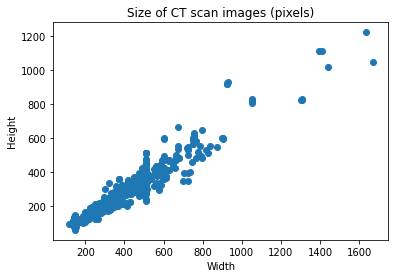

In [ ]:
#Plot CT sizes
import matplotlib.pyplot as plt
plt.scatter(*zip(*size_CT))
plt.title('Size of CT scan images (pixels)')
plt.xlabel('Width')
plt.ylabel('Height')
#Find median size
widths = []
heights = []
for pair in size_CT:
  widths.append(pair[0])
  heights.append(pair[1])

print('Height median is %d, width median is %d' % (np.median(heights), np.median(widths)))
print('Height mean is %d, width mean is %d' % (np.mean(heights), np.mean(widths)))

The plot clearly shows that images within the dataset have variable size, ranging from very small images (i.e. less than 200x200 px) to quite wide images (i.e. 1600x1200 px). 
My choice is to resize all image to a value close to the dataset mean and median (i.e. 300x400 px).

In [37]:
#Since pictures are already divided in different folders representing different categories,
#use ImageFolder to create the dataset 

covid_ds = datasets.ImageFolder(root = '/content/drive/My Drive/COVID_19', transform=transforms.ToTensor())

1


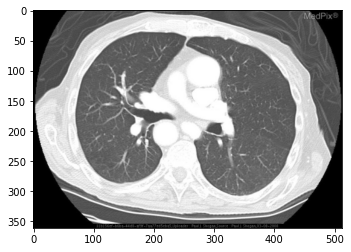

In [ ]:
#Plot 1 image to check dataset integrity
img,label = covid_ds[740]
print(label)
plt.imshow(img.permute(1,2,0))

As second preprocessing step in preparation for dataset transformation, I computed mean and standard deviation of intensity values for each RGB channel across the whole dataset. Output values will be later used to normalize the dataset before running classification.

In [ ]:
#Find mean and for each channel
mean = 0.0
for img, _ in covid_ds:
    mean += img.mean([1,2])
mean = mean/len(dataset)
print(mean)

#And find std of dataset
sumel = 0.0
countel = 0
for img, _ in covid_ds:
    img = (img - mean.unsqueeze(1).unsqueeze(1))**2
    sumel += img.sum([1, 2])
    countel += torch.numel(img[0])
std = torch.sqrt(sumel/countel)
print(std)

tensor([10.0992, 10.0926, 10.0897])
tensor([9.5204, 9.5141, 9.5113])


Now that I have a target dimensionality for my images, and mean and standard deviation of intensity values for each channel, I can apply transformation to the dataset using torchvision.transforms.

In [38]:
#Apply transformation to the dataset
transformations = transforms.Compose([
                                     transforms.Resize((300,400)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((10.0992, 10.0926, 10.0897), 
                                                          (9.5204, 9.5141, 9.5113))
])
covid_ds_transf = datasets.ImageFolder(root = '/content/drive/My Drive/COVID_19', transform=transformations)

After resizing and normalization, I divided the dataset in training (70% of the data), validation and test (15% of the dataset each). 

In [39]:
#Divide the covid_ds_transf dataset in training, validation and test set
train_size = int(0.7 * len(covid_ds_transf))
validation_size = test_size = int((len(covid_ds_transf) - train_size)/2)
print(train_size, validation_size, test_size)

#Split the dataset using random_split (using manual seed to ensure reproducibility)
covid_ds_transf_train, covid_ds_transf_val, covid_ds_transf_test = torch.utils.data.random_split(covid_ds_transf, [train_size, validation_size, test_size], generator=torch.Generator().manual_seed(42))
print(covid_ds_transf_train, covid_ds_transf_val, covid_ds_transf_test)
print(covid_ds_transf_train.indices, covid_ds_transf_val.indices, covid_ds_transf_test.indices)
print(len(covid_ds_transf_test), len(covid_ds_transf_val), len(covid_ds_transf_train))

522 112 112
<torch.utils.data.dataset.Subset object at 0x7ff6b5c102b0> <torch.utils.data.dataset.Subset object at 0x7ff6b5c107f0> <torch.utils.data.dataset.Subset object at 0x7ff6b5c106a0>
[442, 393, 606, 423, 414, 133, 566, 602, 552, 572, 284, 555, 440, 680, 29, 273, 231, 264, 657, 720, 1, 322, 167, 397, 247, 639, 127, 727, 333, 219, 410, 641, 543, 400, 687, 564, 245, 150, 318, 208, 200, 698, 723, 153, 461, 151, 389, 591, 663, 595, 13, 395, 660, 233, 416, 21, 741, 505, 236, 230, 478, 366, 550, 27, 276, 166, 629, 538, 213, 348, 143, 260, 138, 637, 2, 519, 539, 702, 636, 673, 302, 642, 622, 497, 170, 227, 315, 633, 155, 225, 97, 303, 599, 419, 171, 23, 607, 376, 103, 361, 668, 92, 647, 640, 91, 86, 551, 288, 745, 422, 533, 725, 281, 12, 160, 582, 676, 695, 185, 85, 112, 557, 523, 203, 648, 209, 94, 618, 455, 265, 621, 634, 446, 137, 492, 435, 662, 510, 176, 724, 313, 186, 733, 39, 485, 508, 316, 5, 524, 669, 145, 573, 458, 482, 638, 387, 212, 98, 158, 102, 286, 736, 321, 729, 48, 707, 1

**STEP 2**: Models training.
After creating the dataset, next step is model training. For the current task, I chose to use a Residual Network, which at the moment is the state of the art in image classification.
Since the dataset I'm dealing with is quite small, I selected two models with small (i.e. ResNet 18) and intermediate (i.e. ResNet50) depth.
For both models, I will try to perform classification using both pretrained and non-pretrained architectures, and I will compare their perfomances.

In [40]:
#Check if GPU is available
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Training on device {device}.')

Training on device cuda.


The training loop is defined as follows: at each epoch, I computed both training and validation loss. This allowed me to implement early stopping (if validation loss does not decrease after five epochs, the training stops and save the best model).

In [ ]:
#Define the training loop

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader,
                  checkpoint_path):

  #Define parameters for early stopping
  n_epochs_stop = 5
  min_val_loss = np.Inf
  n_epochs_no_improve = 0
  #Define variables to output
  train_losses, val_losses = [], []

  #Start training
  for epoch in range(1, n_epochs + 1):
    print('Epoch {} / {}'.format(epoch, n_epochs))
    train_loss = 0.0
    #Enable dropout
    model.train()
    for imgs, labels in train_loader:
      #Move imgs and labels to the gpu
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      #Feed a batch through the model
      outputs = model(imgs)
      #Compute the loss
      loss = loss_fn(outputs, labels)
      #Zero the gradients
      optimizer.zero_grad()
      #Do backprop and take a step
      loss.backward()
      optimizer.step()
      #Update the loss
      train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
    print('{} Train loss: {:.2f}'.format(datetime.datetime.now(), 
                                         train_loss/len(train_loader)))

    #Check validation accuracy at each epoch
    val_loss = 0.0
    #Disable dropout
    model.eval()
    with torch.no_grad():
      total = 0.0
      correct = 0.0
      accuracy = 0.0
      for imgs, labels in val_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

      #Divide validation loss for number batches
      val_loss_corr = val_loss/len(val_loader)
      val_losses.append(val_loss_corr)
      print('{} Validation loss: {:.2f}, accuracy: {:.2f}'.format(
          datetime.datetime.now(), val_loss_corr, correct/total))
      
      #Implement early stopping
      if val_loss_corr < min_val_loss:
        #Update minimum val_loss
        min_val_loss = val_loss_corr
        #Reset epochs of no improve
        epochs_no_improve = 0
        #Save the model
        torch.save(model, os.path.join(checkpoint_path, 'model.pth'))

      else:
        epochs_no_improve += 1
        #Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
          print('Early stopping!')
          return train_losses, val_losses 

The first model I tested is the pre-trained ResNet18. By setting the parameters.requires_grad to False I freezed all the pre-trained layers, preventing back propagation from modifying them.

In [ ]:
#Select the first model: Resnet 18 pre-trained
model = models.resnet18(pretrained=True)
print(model)

#Enable autograd to fine-tune the model
for param in model.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For each model, I tested multiple combinations of hyperparameters to tune the model, namely 3 different learning rates (i.e. 0.0001, 0.001, 0.01) and 4 levels of dropout that I implemented implement in the final layer (i.e. 0, 0.2, 0.5, 0.8).

In [4]:
#Define learning rates and dropout percentages to test
learn_rates = [0.0001, 0.001, 0.01]
dropout_perc = [0, 0.2, 0.5, 0.8]

#Define all possible combination of learning rate and dropout for testing
import itertools
combinations = list(itertools.product(learn_rates, dropout_perc))
len(combinations)

12

Before training the model, I defined train, validation and test DataLoader (batch_size = 64 images)



In [41]:
#Define train, validation and test loader
train_loader = torch.utils.data.DataLoader(covid_ds_transf_train, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(covid_ds_transf_val, batch_size = 64, shuffle = False)
test_loader = torch.utils.data.DataLoader(covid_ds_transf_test, batch_size = 64, shuffle = False)

**Model training**: I testd the Resnet 18 pre-trained model for each combination of learning rate and dropout percentage. For each combination, the training loop will save in the corresponding folder the model with the lowest validation loss.
To adapt the Resnet 18 to the dataset, I modified the final layer of the model. After a linear layer and a ReLU activation function, I inserted a module controlling the dropout, and a final linear layer giving two features as ouput (n_classes = 2, COVID/NON_COVID CT scans).
I used the CrossEntropy loss as loss function, and Adam as optimizer.
Adam will update only the final layer parameters during back propagation.

In [ ]:
#Train Resnet18

for i in range(len(combinations)):
  #Unpack selected lr and dropout
  lr, drop = combinations[i]

  #Create folder for saving the model
  checkpoint_path = '/content/drive/My Drive/COVID_19/models/resnet18_lr{}_dropout{}'.format(lr, drop)
  os.mkdir(checkpoint_path)

  #Apply dropout to final layer model
  model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(drop),
                                 nn.Linear(256, 2))
  model.to(device)
  
  #Define loss function
  loss_fn = nn.CrossEntropyLoss()
  
  #Define learning rate for optimizer
  optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
  
  #Start the training loop
  print('Model: Resnet18, lr: {}, dropout: {}'.format(lr, drop))
  train_losses, val_losses = training_loop(
      n_epochs = 1000,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      checkpoint_path = checkpoint_path)
  
  #Save train and val losses in checkpoint path for later use
  np.save(os.path.join(checkpoint_path, 'train_losses.npy'), train_losses)
  np.save(os.path.join(checkpoint_path, 'validation_losses.npy'), val_losses)

Model: Resnet18, lr: 0.0001, dropout: 0
Epoch 1 / 1000
2021-01-12 15:19:22.570571 Train loss: 0.70
2021-01-12 15:19:23.770023 Validation loss: 0.67, accuracy: 0.56
Epoch 2 / 1000
2021-01-12 15:19:30.993846 Train loss: 0.65
2021-01-12 15:19:32.204031 Validation loss: 0.69, accuracy: 0.54
Epoch 3 / 1000
2021-01-12 15:19:39.477866 Train loss: 0.63
2021-01-12 15:19:40.661720 Validation loss: 0.68, accuracy: 0.57
Epoch 4 / 1000
2021-01-12 15:19:47.622806 Train loss: 0.60
2021-01-12 15:19:48.798079 Validation loss: 0.66, accuracy: 0.58
Epoch 5 / 1000
2021-01-12 15:19:56.041002 Train loss: 0.58
2021-01-12 15:19:57.214991 Validation loss: 0.64, accuracy: 0.59
Epoch 6 / 1000
2021-01-12 15:20:04.796311 Train loss: 0.56
2021-01-12 15:20:05.994411 Validation loss: 0.61, accuracy: 0.59
Epoch 7 / 1000
2021-01-12 15:20:13.298855 Train loss: 0.54
2021-01-12 15:20:14.474181 Validation loss: 0.58, accuracy: 0.68
Epoch 8 / 1000
2021-01-12 15:20:21.818309 Train loss: 0.54
2021-01-12 15:20:23.034067 Valida

After the training, I plotted the performance of the Resnet 18 pre-trained model for each combination of learning rate and dropout percentage.

In [25]:
#Plot models performances
def plot_perf(combinations, model):
  fig = plt.figure(figsize=(20,20))
  for i in range(len(combinations)):
    #Unpack current model lr and dropout
    lr, drop = combinations[i]
    #Load train and validation losses for current model
    train_loss = np.load(os.path.join('/content/drive/My Drive/COVID_19/models/',
                                      '{}_lr{}_dropout{}'.format(model, lr, drop),
                                      'train_losses.npy'))
    val_loss = np.load(os.path.join('/content/drive/My Drive/COVID_19/models/',
                                      '{}_lr{}_dropout{}'.format(model, lr, drop),
                                      'validation_losses.npy'))
    #Plot training and validation losses
    ax = plt.subplot(4, 3, i+1)
    ax.plot(train_loss, label='Training loss')
    ax.plot(val_loss, label='Validation loss')
    ax.axvline(x=(len(train_loss)-6), color='r', linestyle='--')
    ax.legend(frameon=False)
    plt.title('{} lr={} dropout = {}\nTraining loss: {:.2f}, validation loss: {:.4f}\n(Red scattered line represents early stopping)'.format(model, lr, drop, train_loss[-6], val_loss[-6]))
  fig.tight_layout(pad = 2)

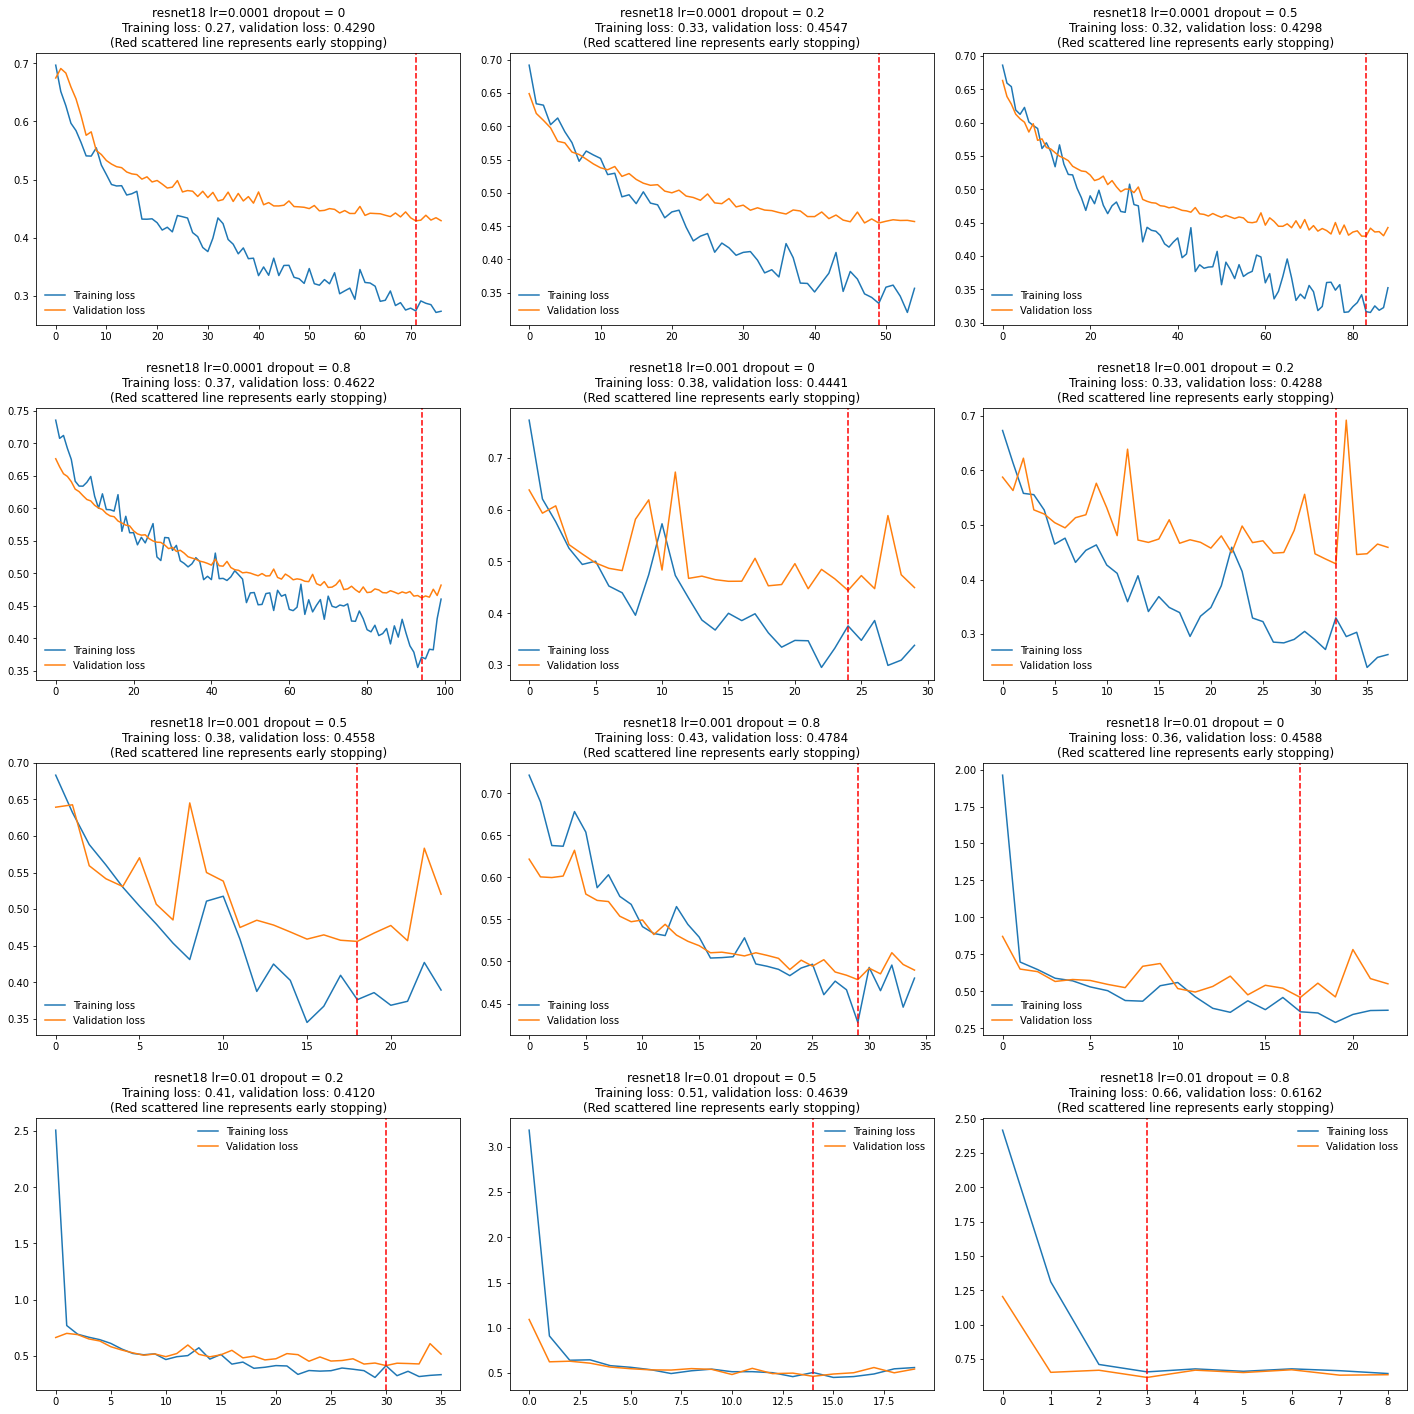

In [26]:
#Plot Resnet18 performances (scattered red line represents early stopping)
plot_perf(combinations, 'resnet18')

Based on the plots and on the validation loss, the best model seems to be the Resent 18 pre-trained with learning rate = 0.01 and dropout = 0.2

As last step, I tested the accuracy on the test set.

In [35]:
def test_accuracy_best_model(model, lr, drop, test_loader):
  #Load best model (lr=0.01, dropout = 0.2)
  model = torch.load(os.path.join('/content/drive/My Drive/COVID_19/models/',
                                      '{}_lr{}_dropout{}'.format(model, lr, drop),
                                      'model.pth'))
  model.to(device)
  model.eval()

  #Check accuracy on test set
  with torch.no_grad():
    total = 0.0
    correct = 0.0
    accuracy = 0.0
    for imgs, labels in test_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
  print('Test set accuracy: {:.2f}'.format(correct/total))
  return (correct/total)

In [42]:
#Test accuracy of best model on test set
acc_resnet18 = test_accuracy_best_model('resnet18', 0.001, 0.2, test_loader)

Test set accuracy: 0.77


The pre-trained Resnet 18 model reached 77% accuracy on the test set.

I then tested a deeper model (i.e. Resnet 50) pretrained, using the same combinations of learning rates and dropout percentages.

In [ ]:
#Second model: Resnet50
#Load pretrained model to perform classification
model = models.resnet50(pretrained=True)
print(model)

#Enable autograd to fine-tune the model
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

As for the Resnet 18, I adapted the final layer of the model using the same reasoning. Loss function and optimizer are the same.

In [ ]:
#Train the model

for i in range(len(combinations)):
  #Unpack selected lr and dropout
  lr, drop = combinations[i]

  #Create folder for saving the model
  checkpoint_path = '/content/drive/My Drive/COVID_19/models/resnet50_lr{}_dropout{}'.format(lr, drop)
  os.mkdir(checkpoint_path)

  #Apply dropout to final layer model
  model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(drop),
                                 nn.Linear(512, 2))
  model.to(device)
  
  #Define loss function
  loss_fn = nn.CrossEntropyLoss()
  
  #Define learning rate for optimizer
  optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
  
  #Start the training loop
  print('Model: Resnet50, lr: {}, dropout: {}'.format(lr, drop))
  train_losses, val_losses = training_loop(
      n_epochs = 1000,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      checkpoint_path = checkpoint_path)
  
  #Save train and val losses in checkpoint path for later use
  np.save(os.path.join(checkpoint_path, 'train_losses.npy'), train_losses)
  np.save(os.path.join(checkpoint_path, 'validation_losses.npy'), val_losses)

Model: Resnet50, lr: 0.0001, dropout: 0
Epoch 1 / 1000
2021-01-12 16:45:07.068658 Train loss: 0.68
2021-01-12 16:45:08.560749 Validation loss: 0.68, accuracy: 0.56
Epoch 2 / 1000
2021-01-12 16:45:20.616635 Train loss: 0.67
2021-01-12 16:45:22.091833 Validation loss: 0.68, accuracy: 0.59
Epoch 3 / 1000
2021-01-12 16:45:33.543009 Train loss: 0.60
2021-01-12 16:45:35.019561 Validation loss: 0.69, accuracy: 0.56
Epoch 4 / 1000
2021-01-12 16:45:46.421442 Train loss: 0.60
2021-01-12 16:45:47.888081 Validation loss: 0.69, accuracy: 0.52
Epoch 5 / 1000
2021-01-12 16:45:59.262713 Train loss: 0.63
2021-01-12 16:46:00.755569 Validation loss: 0.63, accuracy: 0.67
Epoch 6 / 1000
2021-01-12 16:46:12.726019 Train loss: 0.56
2021-01-12 16:46:14.243659 Validation loss: 0.61, accuracy: 0.69
Epoch 7 / 1000
2021-01-12 16:46:26.120136 Train loss: 0.56
2021-01-12 16:46:27.657843 Validation loss: 0.65, accuracy: 0.62
Epoch 8 / 1000
2021-01-12 16:46:38.994388 Train loss: 0.53
2021-01-12 16:46:40.441599 Valida

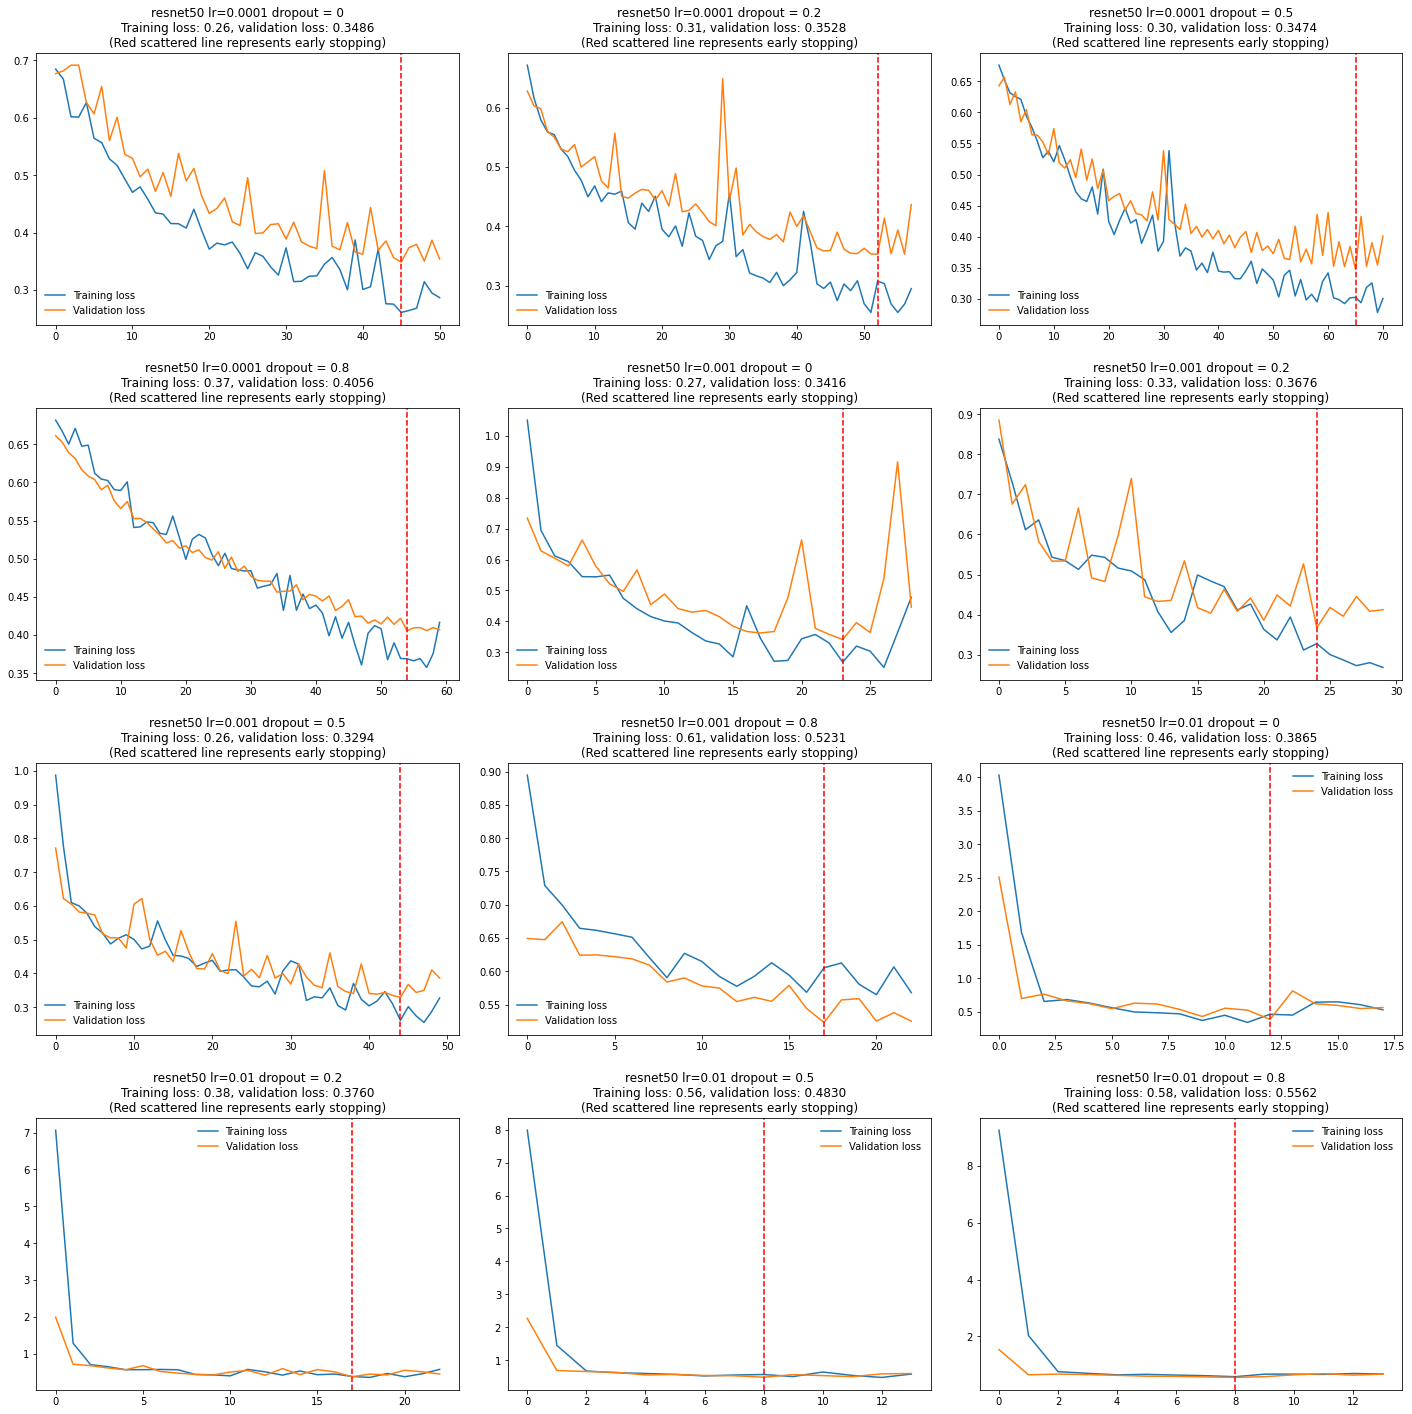

In [27]:
#Plot models performances
plot_perf(combinations, 'resnet50')

By looking at plots, the best model seems to be the Resnet50 pre-trained with learning rate = 0.001 and dropout percentage = 0.5

I then tested the accuracy on the test set.

In [43]:
#Test accuracy of best model on test set
acc_resnet50 = test_accuracy_best_model('resnet50', 0.001, 0.5, test_loader)

Test set accuracy: 0.81


The Resnet50 pre-trained model reached 81% accuracy on the test set, +4% compared to Resnet 18.

As further step, I wanted to test whether the pre-training of both Resnet 18 and 50 is beneficial for this specific classification task. To this aim, I tried and used a non-pretrained version of both models. I set parameters.requires_grad to True in order to update via back propagation all parameters in the model.

The first non-pretrained model I tested was the one that performed better in the previous comparison (i.e. Resnet 50)

In [ ]:
#Last model to test: Resnet 50
#Load pretrained model to perform classification
model = models.resnet50(pretrained=False)
print(model)

#Enable autograd to fine-tune the model
for param in model.parameters():
    param.requires_grad = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

As before, I tested the same combinations of learning rate and dropout, using the same loss function, optimizer and architecture of the final layer. The only critical difference this time is that I passed to the optimizer all parameters for back propagation, and not only the final layer.

In [ ]:
#Train the model

for i in range(len(combinations)):
  #Unpack selected lr and dropout
  lr, drop = combinations[i]

  #Create folder for saving the model
  checkpoint_path = '/content/drive/My Drive/COVID_19/models/resnet50_all_params_npt_lr{}_dropout{}'.format(lr, drop)
  os.mkdir(checkpoint_path)

  #Apply dropout to final layer model
  model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(drop),
                                 nn.Linear(512, 2))
  model.to(device)
  
  #Define loss function
  loss_fn = nn.CrossEntropyLoss()
  
  #Define learning rate for optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  #Start the training loop
  print('Model: Resnet50 all_params, lr: {}, dropout: {}'.format(lr, drop))
  train_losses, val_losses = training_loop(
      n_epochs = 1000,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      checkpoint_path = checkpoint_path)
  
  #Save train and val losses in checkpoint path for later use
  np.save(os.path.join(checkpoint_path, 'train_losses.npy'), train_losses)
  np.save(os.path.join(checkpoint_path, 'validation_losses.npy'), val_losses)

Model: Resnet50 all_params, lr: 0.0001, dropout: 0
Epoch 1 / 1000
2021-01-14 17:02:34.374803 Train loss: 0.70
2021-01-14 17:03:00.953532 Validation loss: 0.69, accuracy: 0.52
Epoch 2 / 1000
2021-01-14 17:03:19.126677 Train loss: 0.58
2021-01-14 17:03:20.913193 Validation loss: 0.72, accuracy: 0.37
Epoch 3 / 1000
2021-01-14 17:03:38.657247 Train loss: 0.55
2021-01-14 17:03:40.513692 Validation loss: 0.90, accuracy: 0.56
Epoch 4 / 1000
2021-01-14 17:03:58.652347 Train loss: 0.58
2021-01-14 17:04:00.535028 Validation loss: 0.96, accuracy: 0.56
Epoch 5 / 1000
2021-01-14 17:04:19.178022 Train loss: 0.50
2021-01-14 17:04:21.030565 Validation loss: 1.16, accuracy: 0.56
Epoch 6 / 1000
2021-01-14 17:04:38.981275 Train loss: 0.46
2021-01-14 17:04:40.805001 Validation loss: 1.13, accuracy: 0.56
Early stopping!
Model: Resnet50 all_params, lr: 0.0001, dropout: 0.2
Epoch 1 / 1000
2021-01-14 17:04:58.681560 Train loss: 0.56
2021-01-14 17:05:00.518158 Validation loss: 0.70, accuracy: 0.54
Epoch 2 / 10

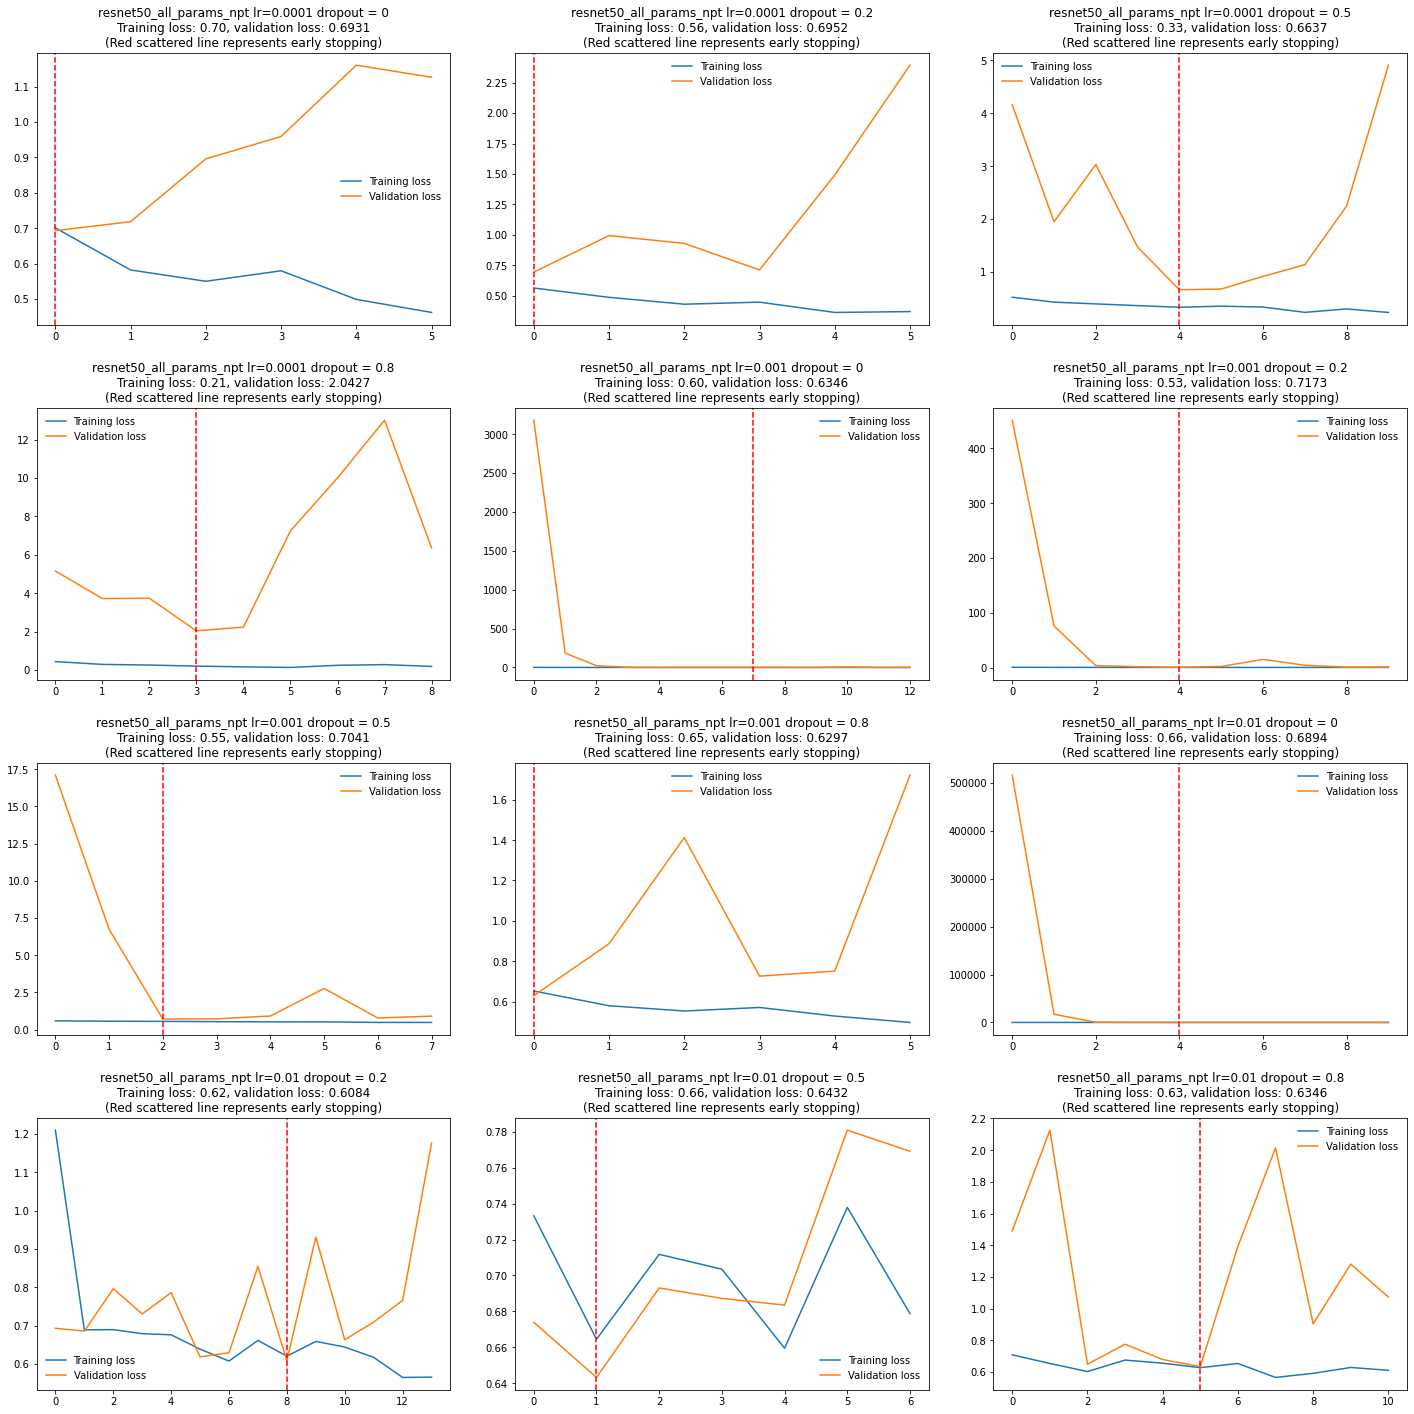

In [31]:
#Plot models performances
plot_perf(combinations, 'resnet50_all_params_npt')

The best performing version of the model is using a learning rate of 0.01 and a dropout percentage of 0.2

In [45]:
#Test accuracy of best model on test set
acc_resnet50_npt = test_accuracy_best_model('resnet50_all_params_npt', 0.01, 0.2, test_loader)

Test set accuracy: 0.71


The non-pretrained model shows a substantial decrease in accuracy (-10% compared to the pre-trained).

I performed the same analysis for Resnet 18.

In [ ]:
#Load pretrained model to perform classification
model = models.resnet18(pretrained=False)
print(model)

#Enable autograd to fine-tune the model
for param in model.parameters():
    param.requires_grad = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Train the model

for i in range(len(combinations)):
  #Unpack selected lr and dropout
  lr, drop = combinations[i]

  #Create folder for saving the model
  checkpoint_path = '/content/drive/My Drive/COVID_19/models/resnet18_all_params_npt_lr{}_dropout{}'.format(lr, drop)
  os.mkdir(checkpoint_path)

  #Apply dropout to final layer model
  model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(drop),
                                 nn.Linear(256, 2))
  model.to(device)
  
  #Define loss function
  loss_fn = nn.CrossEntropyLoss()
  
  #Define learning rate for optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  #Start the training loop
  print('Model: Resnet18 all_params, lr: {}, dropout: {}'.format(lr, drop))
  train_losses, val_losses = training_loop(
      n_epochs = 1000,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      checkpoint_path = checkpoint_path)
  
  #Save train and val losses in checkpoint path for later use
  np.save(os.path.join(checkpoint_path, 'train_losses.npy'), train_losses)
  np.save(os.path.join(checkpoint_path, 'validation_losses.npy'), val_losses)

Model: Resnet18 all_params, lr: 0.0001, dropout: 0
Epoch 1 / 1000
2021-01-14 17:41:34.520960 Train loss: 0.64
2021-01-14 17:41:35.707523 Validation loss: 0.69, accuracy: 0.56
Epoch 2 / 1000
2021-01-14 17:41:44.366602 Train loss: 0.52
2021-01-14 17:41:45.574031 Validation loss: 0.72, accuracy: 0.56
Epoch 3 / 1000
2021-01-14 17:41:54.133934 Train loss: 0.47
2021-01-14 17:41:55.324679 Validation loss: 0.72, accuracy: 0.56
Epoch 4 / 1000
2021-01-14 17:42:03.902063 Train loss: 0.47
2021-01-14 17:42:05.105218 Validation loss: 0.74, accuracy: 0.50
Epoch 5 / 1000
2021-01-14 17:42:13.710220 Train loss: 0.41
2021-01-14 17:42:14.924624 Validation loss: 1.05, accuracy: 0.41
Epoch 6 / 1000
2021-01-14 17:42:23.543519 Train loss: 0.47
2021-01-14 17:42:24.753877 Validation loss: 0.96, accuracy: 0.40
Early stopping!
Model: Resnet18 all_params, lr: 0.0001, dropout: 0.2
Epoch 1 / 1000
2021-01-14 17:42:33.335594 Train loss: 0.54
2021-01-14 17:42:34.541470 Validation loss: 0.85, accuracy: 0.56
Epoch 2 / 10

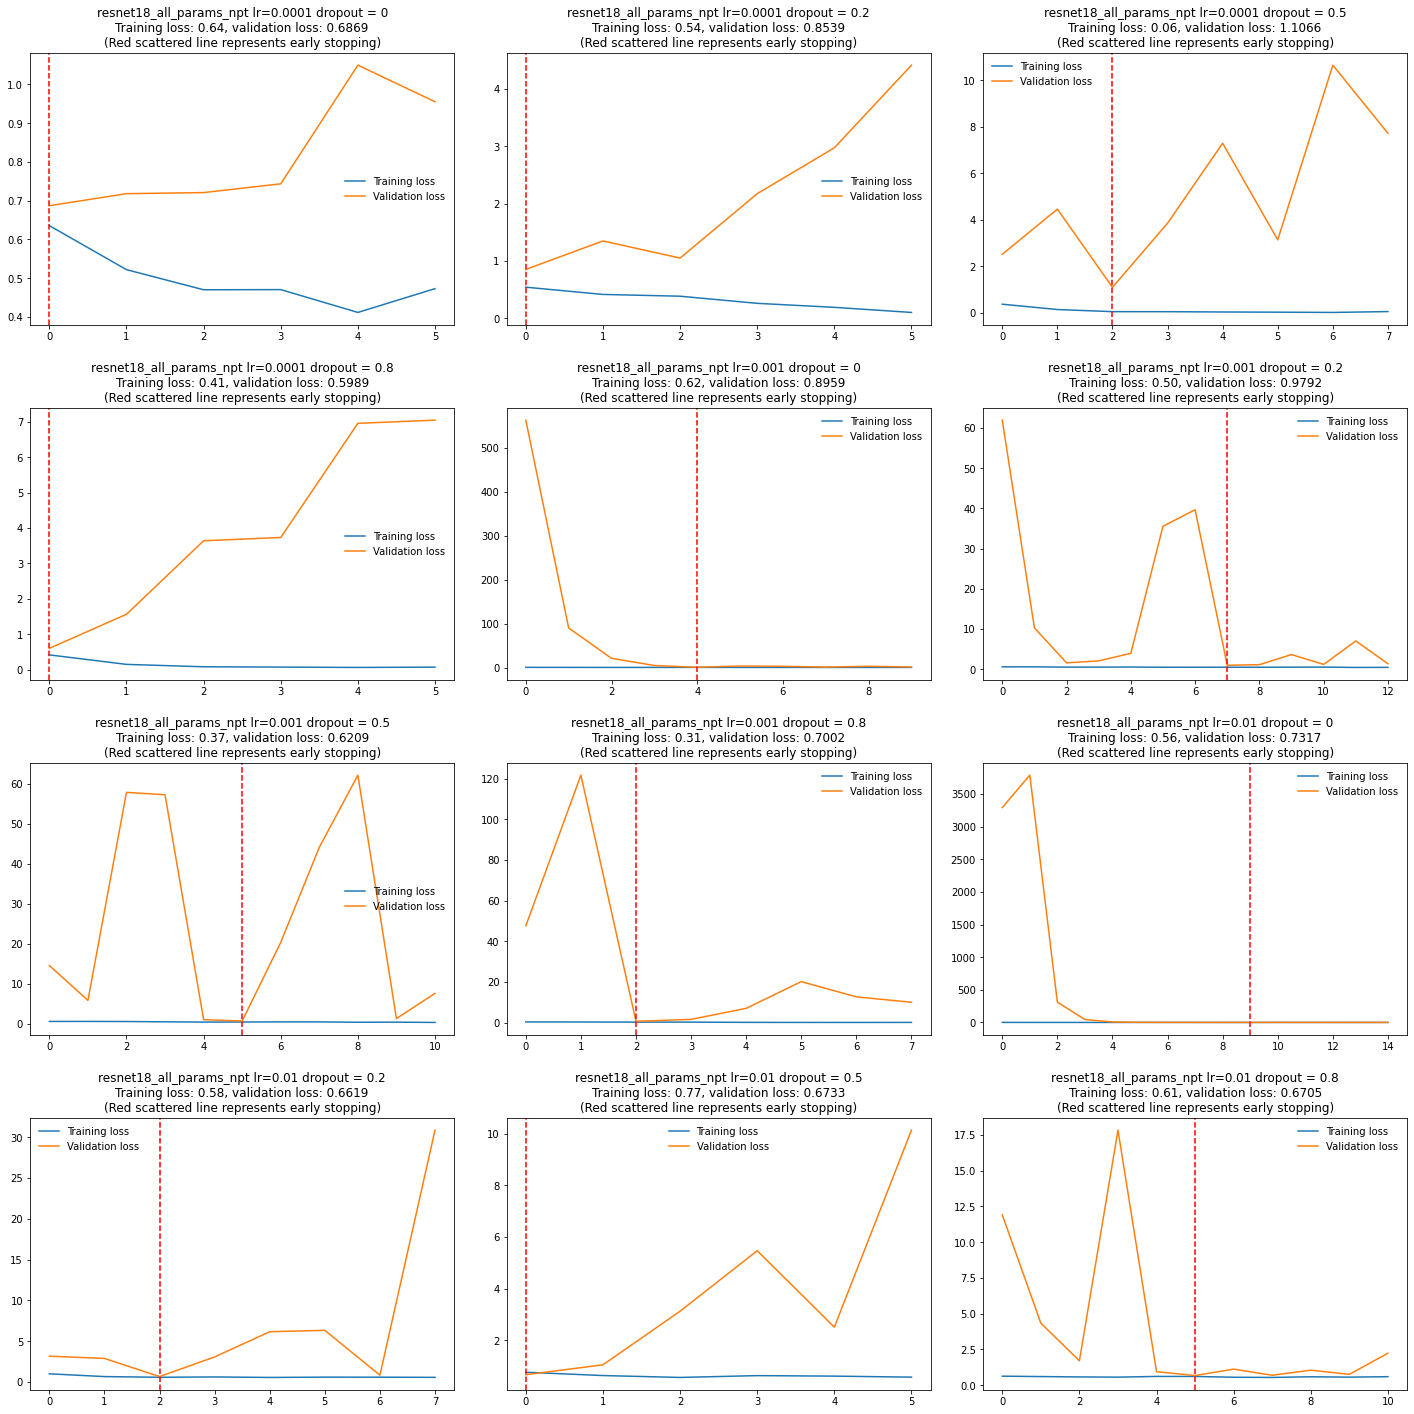

In [32]:
#Plot models performances
plot_perf(combinations, 'resnet18_all_params_npt')

The best performing combination of hyperparameters is learning rate = 0.0001 and dropout = 0.8. From the plot, however, it seems that the model is overfitting the training data (validation loss increasing after the 1st epoch).

In [46]:
#Test accuracy of best model on test set
acc_resnet18_npt = test_accuracy_best_model('resnet18_all_params_npt', 0.0001, 0.8, test_loader)

Test set accuracy: 0.73


Accuracy on the test set also in this case is lower than the pre-trained model (-4%).

**STEP 3**: Summary and potential follow-up

As can be seen in the plot below, of all tested model the Resnet 50 pre-trained seems to be the best in classifying CT scans for COVID-19 diagnosis with a test set accuracy of 81%.

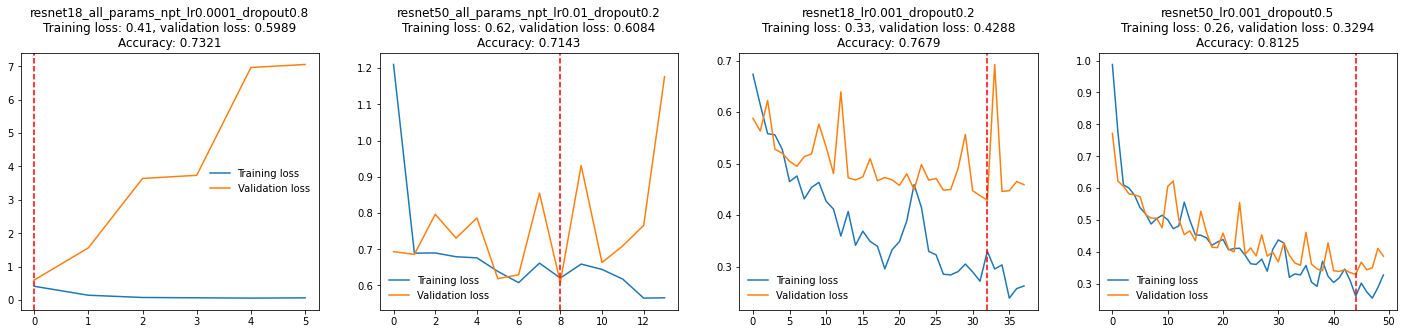

In [51]:
#Plot the best models

best_models = ['resnet18_all_params_npt_lr0.0001_dropout0.8',
               'resnet50_all_params_npt_lr0.01_dropout0.2',
               'resnet18_lr0.001_dropout0.2', 'resnet50_lr0.001_dropout0.5']
accuracies = [acc_resnet18_npt, acc_resnet50_npt, acc_resnet18, acc_resnet50]

fig = plt.figure(figsize=(20,5))

for i in range(len(best_models)):
    #Load train and validation losses for current model
    train_loss = np.load(os.path.join('/content/drive/My Drive/COVID_19/models/',
                                      '{}'.format(best_models[i]),
                                      'train_losses.npy'))
    val_loss = np.load(os.path.join('/content/drive/My Drive/COVID_19/models/',
                                      '{}'.format(best_models[i]),
                                      'validation_losses.npy'))
    #Plot training and validation losses
    ax = plt.subplot(1, 4, i+1)
    ax.plot(train_loss, label='Training loss')
    ax.plot(val_loss, label='Validation loss')
    ax.legend(frameon=False)
    ax.axvline(x=(len(train_loss)-6), color='r', linestyle='--')
    plt.title('{}\nTraining loss: {:.2f}, validation loss: {:.4f}\nAccuracy: {:.4f}'.format(best_models[i], train_loss[-6], 
    val_loss[-6], accuracies[i]))
fig.tight_layout(pad = 2)

As last step, I thought about looking at all misclassified test images by the pre-trained Resnet 50. This would allow me to understand whether there are similarities between them, and to identify potential image features driving classification errors.

I first got the misclassified images, with the correct label and the model prediction

In [ ]:
#Find index of best model prediction errors

#Load best model (lr=0.01, dropout = 0.2)
model = torch.load(os.path.join('/content/drive/My Drive/COVID_19/models/resnet50_lr0.001_dropout0.5',
                                    'model.pth'))
model.to(device)
model.eval()

#Check accuracy on test set
with torch.no_grad():
  wrong_predictions = []
  correct_class = []
  predicted_class = []
  for imgs, labels in test_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, dim=1)
      # Store wrongly predicted images
      idxs_mask = ((predicted == labels) == False).view(-1)
      wrong_predictions.append(imgs[idxs_mask].cpu())
      correct_class.append(labels[idxs_mask].cpu().numpy())
      predicted_class.append(predicted[idxs_mask].cpu().numpy())

I then defined a class to reverse the normalization performed on each image of the dataset,

In [ ]:
#Define class to un-normalize images
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

#Instantiate the class
unnorm = UnNormalize(mean=(10.0992, 10.0926, 10.0897),std=(9.5204, 9.5141, 9.5113))

And since the dataset is quite small, plotted all of them (total: 21).

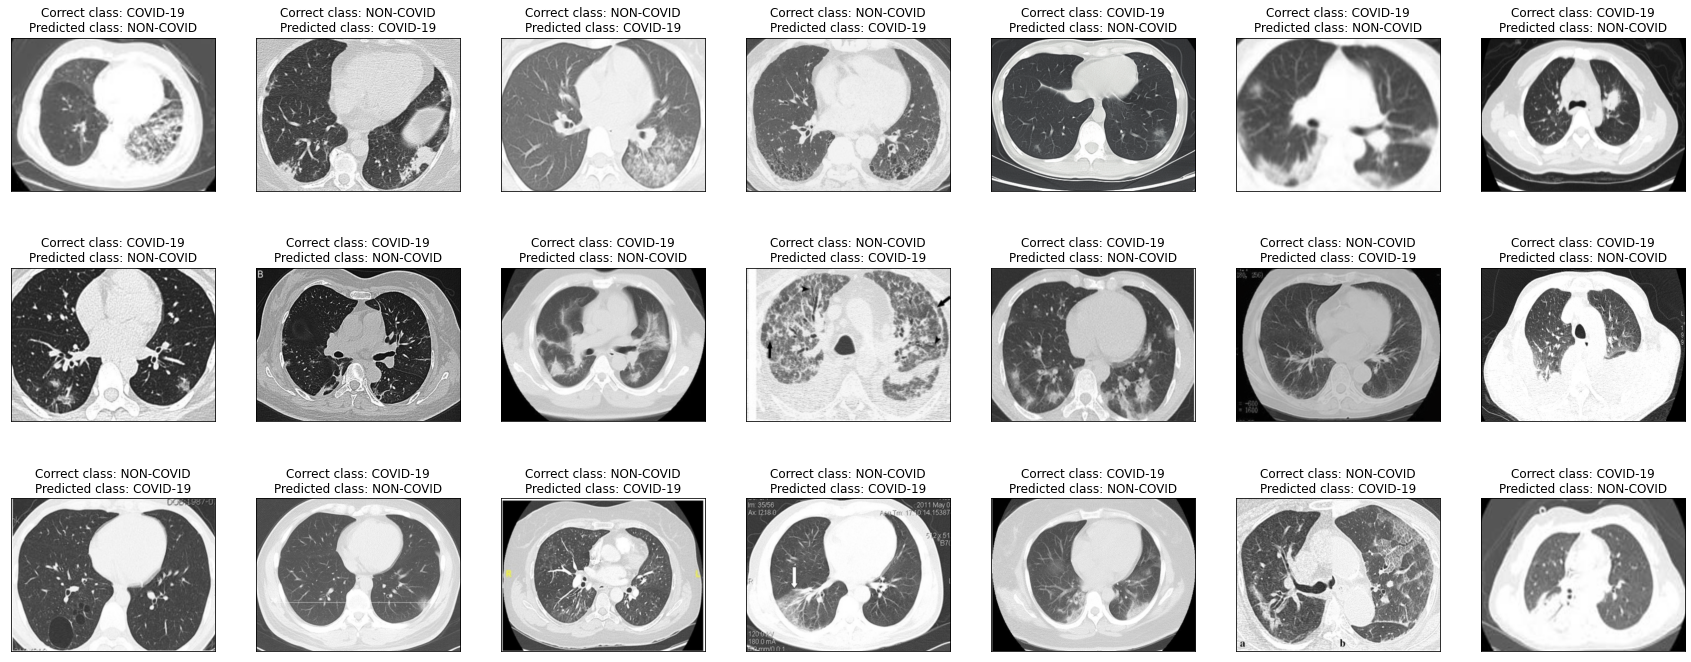

In [ ]:
fig = plt.figure(figsize=(30, 12))

i = 0
for idx1 in range(len(wrong_predictions)):
  for idx2 in range(len(wrong_predictions[idx1])):
    i += 1
    ax = fig.add_subplot(3, 7, i, xticks=[], yticks=[])
    img = unnorm(wrong_predictions[idx1][idx2]).permute(1,2,0)
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title("Correct class: {}\nPredicted class: {}".format("COVID-19" if correct_class[idx1][idx2] == 0 else "NON-COVID", "COVID-19" if predicted_class[idx1][idx2] == 0 else "NON-COVID"))

From a first look at them, it seems that in general images differ a lot for their contrast, and that the brighter ones are more often classified as COVID-19 CT with respect to darker ones. One potential way to address the issue might be to perform data augmentation, and creating synthetic copies of the training set varying the contrast.

**SUMMARY**: The Resnet 50 model was able to detect the presence of COVID-19 related signs in CT scans with a good accuracy (81%). The pre-training of the model on the MNIST dataset is beneficial for the current classification task. It has to be noted, however, that, as reported by the authors, the following dataset has some limitations:


1.   CT images are represented by a single slice and not the whole volume
2.   Since images are collected from scientific papers, in many cases the resolution is quite low
3.   Some images have annotations (e.g. letters, symbols) superimposed on the original image

Regarding the first two points, the authors state that these are not real concerns, since experienced practitioners (e.g. radiologists) are able to diagnose a disease based on a single slice of a CT scan, even if in low resolution, so these two elements shouldn't affect classification. Annotations, on the other hand, might be more of a concern and affect classification accuracy. 

